In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/ronak/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
df = pd.read_csv('/mnt/d/MachineLearning/Age_detection/age_gender.csv')
df.head(
)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
def process_pixels(pixel_str):
    return np.array(list(map(int, pixel_str.split())))

In [5]:
df['pixels'] = df['pixels'].apply(process_pixels)
x = np.array(df['pixels'].tolist())  # Converts the list of pixel arrays into a 2D array

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming df contains both 'pixels' and 'age' columns
# 'pixels' is a column with pixel data, and 'age' is continuous data

# Reshape pixel data to 48x48 grayscale images
X = np.array([np.array(p).reshape(48, 48, 1) for p in df['pixels'].values])  # Reshape to (height, width, 1)

# Repeat channels to convert grayscale to RGB
X = np.repeat(X, 3, axis=-1)  # Now X will be (num_samples, 48, 48, 3)

# Extract age labels (continuous data)
y_age = df['age'].values  # Age labels (continuous data)

# Split the dataset into train and test sets for age prediction
x_train, x_test, y_train_age, y_test_age = train_test_split(
    X, y_age, test_size=0.2, random_state=42
)

# Now, x_train, x_test, y_train_age, y_test_age are ready for age prediction


In [7]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Assuming x_train has already been defined and contains the training data
IMG_SIZE = x_train.shape[1]  # Assuming the images are square
input_shape = (IMG_SIZE, IMG_SIZE, 3)

# Load the ResNet50 model without the top layer (pre-trained on ImageNet)
base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')

# Define input layer
input_layer = Input(shape=input_shape)

# Add ResNet base model
x = base_model(input_layer)
x = GlobalAveragePooling2D()(x)

# Add the output layer for age prediction
age_output = Dense(1, activation='linear', name='age_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=age_output)

# Compile the model for age prediction
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mean_squared_error',  # For continuous value prediction
              metrics=['mae'])  # Mean Absolute Error for regression tasks

# Model summary
model.summary()


2024-09-27 19:27:13.714833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 19:27:13.963314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 19:27:14.030506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 19:27:14.638365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 19:27:16.434526: W tensorflow/compiler/tf2

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_output (Dense)              │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [9]:
# Assuming y_train_age contains the age labels (continuous values)
history = model.fit(x_train, y_train_age, 
                    validation_split=0.2, epochs=30, batch_size=32)
model.save('./Age_model.keras')

2024-09-27 19:27:35.919110: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 419447808 exceeds 10% of free system memory.
2024-09-27 19:27:36.510299: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 419447808 exceeds 10% of free system memory.


Epoch 1/30


I0000 00:00:1727445483.713011    2710 service.cc:146] XLA service 0x7faf18002b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727445483.713059    2710 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-09-27 19:28:04.682298: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-27 19:28:08.388084: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1727445512.283807    2710 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


475/475 ━━━━━━━━━━━━━━━━━━━━ 106s 106ms/step - loss: 567.1516 - mae: 17.5994 - val_loss: 530.3555 - val_mae: 17.0591
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 82.7614 - mae: 6.6118 - val_loss: 161.3055 - val_mae: 9.0714
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 54.6253 - mae: 5.3600 - val_loss: 89.0058 - val_mae: 6.6410
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 38.7348 - mae: 4.6219 - val_loss: 87.4795 - val_mae: 6.4995
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 30.2473 - mae: 4.0805 - val_loss: 89.5977 - val_mae: 6.5237
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 23.5776 - mae: 3.5899 - val_loss: 110.1857 - val_mae: 7.5687
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 20.7136 - mae: 3.3638 - val_loss: 74.3808 - val_mae: 6.1104
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 15.0988 - mae: 2.9087 - val_loss: 75.7176 - val_mae: 6.0778
Epoch 9/30
475/475 ━━━━━━━━

In [10]:
# Assuming y_test_age contains the age labels (continuous values)
test_loss, test_age_mae = model.evaluate(x_test, y_test_age)

# Print results
print(f"Test Age MAE: {test_age_mae} years")


  1/149 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 83.4965 - mae: 6.8984

2024-09-27 19:37:29.417746: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 131079168 exceeds 10% of free system memory.
2024-09-27 19:37:29.469903: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 131079168 exceeds 10% of free system memory.


149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 73.5951 - mae: 5.8690
Test Age MAE: 5.986982345581055 years


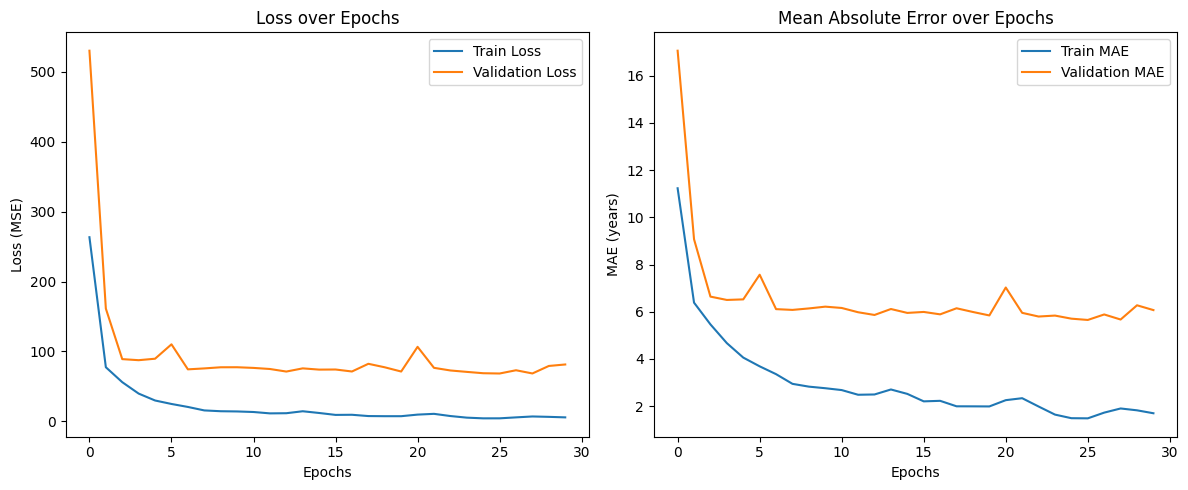

In [11]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and have 'history' object
# history.history contains the training loss and metrics

# Plot loss over epochs
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot Mean Absolute Error (MAE) over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE (years)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
